In [1]:
import numpy as np
import pandas as pd
import re

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import MultiLabelBinarizer
import ast

In [2]:
df = pd.read_csv('../Dataset/Processed/gurgaon_properties_cleaned.csv')
df.duplicated().sum()

122

In [3]:
df.sample(5)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features
73,flat,eldeco accolade,sohna road,0.73,5775.0,1264.0,Super Built up area 1264(117.43 sq.m.)Carpet a...,2,2,3,pooja room,5.0,West,1 to 5 Year Old,"['Global City Centre', 'Sohna Road', 'Damdama ...",NaN,"['Feng Shui / Vaastu Compliant', 'Intercom Fac..."
3018,house,independent,sector 11,3.50,15555.0,2250.0,Built Up area: 2250 (209.03 sq.m.),10,1,0,not available,1.0,NaN,0 to 1 Year Old,"['Rajiv Chowk Mosque', 'Hanuman Mandir', 'Stat...","['1 Light', 'No AC', 'No Bed', 'No Chimney', '...",NaN
1927,flat,godrej nature plus,sector 33,1.45,15664.0,926.0,Built Up area: 118 Carpet area: 86 sq.m.,3,2,3+,study room,20.0,NaN,Under Construction,"['Signature Global Infinity Mall Sohna', 'Bads...",NaN,"['Security / Fire Alarm', 'Feng Shui / Vaastu ..."
2192,flat,paras dews,sector 106,1.42,6029.0,2355.0,Super Built up area 2355(218.79 sq.m.),4,6,3+,servant room,11.0,North-East,1 to 5 Year Old,"['MG Road Metro Station', 'NeoSquare Shopping ...",[],"['Centrally Air Conditioned', 'Security / Fire..."
2508,flat,m3m heights,sector 65,1.90,15000.0,1267.0,Super Built up area 1261(117.15 sq.m.),2,2,3,not available,4.0,NaN,By 2024,"['Rapid Metro Sector 56', 'M3m 65th Avenue Mal...",[],"['Power Back-up', 'Intercom Facility', 'Lift(s..."


### 1. areaWithType

In [4]:
df.sample(5)[['price','area','areaWithType']]

,price,area,areaWithType
146,5.50,300.0,Plot area 300(27.87 sq.m.)
2058,6.30,1800.0,Plot area 200(167.23 sq.m.)
266,3.93,1623.0,Plot area 1623(150.78 sq.m.)Built Up area: 162...
682,8.00,7000.0,Plot area 7000(650.32 sq.m.)
2122,0.80,1360.0,Built Up area: 1360 (126.35 sq.m.)


In [5]:
# This function extracts the Super Built up area
def get_super_built_up_area(text):
    match = re.search(r'Super Built up area (\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

# This function extracts the Built Up area or Carpet area
def get_area(text, area_type):
    match = re.search(area_type + r'\s*:\s*(\d+\.?\d*)', text)
    if match:
        return float(match.group(1))
    return None

# This function checks if the area is provided in sq.m. and converts it to sqft if needed
def convert_to_sqft(text, area_value):
    if area_value is None:
        return None
    match = re.search(r'{} \((\d+\.?\d*) sq.m.\)'.format(area_value), text)
    if match:
        sq_m_value = float(match.group(1))
        return sq_m_value * 10.7639  # conversion factor from sq.m. to sqft
    return area_value

# Function to extract plot area from 'areaWithType' column
def extract_plot_area(area_with_type):
    match = re.search(r'Plot area (\d+\.?\d*)', area_with_type)
    return float(match.group(1)) if match else None

In [6]:
# Extract Super Built up area and convert to sqft if needed
df['super_built_up_area'] = df['areaWithType'].apply(get_super_built_up_area)
df['super_built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['super_built_up_area']), axis=1)

# Extract Built Up area and convert to sqft if needed
df['built_up_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Built Up area'))
df['built_up_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['built_up_area']), axis=1)

# Extract Carpet area and convert to sqft if needed
df['carpet_area'] = df['areaWithType'].apply(lambda x: get_area(x, 'Carpet area'))
df['carpet_area'] = df.apply(lambda x: convert_to_sqft(x['areaWithType'], x['carpet_area']), axis=1)

In [7]:
df[['price','property_type','area','areaWithType','super_built_up_area','built_up_area','carpet_area']].sample(5)

,price,property_type,area,areaWithType,super_built_up_area,built_up_area,carpet_area
3206,1.15,flat,1744.0,Super Built up area 1365(126.81 sq.m.),1365.0,NaN,NaN
1426,1.75,flat,1950.0,Built Up area: 1950 (181.16 sq.m.),NaN,1950.0,NaN
745,1.45,flat,1480.0,Built Up area: 1480 (137.5 sq.m.)Carpet area: ...,NaN,1480.0,1050.00
3451,6.00,house,2430.0,Plot area 270(225.75 sq.m.),NaN,NaN,NaN
1370,1.30,flat,1490.0,Super Built up area 1490(138.43 sq.m.)Built Up...,1490.0,1176.0,863.91


In [8]:
# No. of rows where all 3 types of area are not null
df[~((df['super_built_up_area'].isnull()) | (df['built_up_area'].isnull()) | (df['carpet_area'].isnull()))].shape[0]

534

In [9]:
# Assigning plot area of all_nan_df to built_up_area
all_nan_df = df[df['built_up_area'].isnull() & df['super_built_up_area'].isnull() & df['carpet_area'].isnull()]
all_nan_df['built_up_area'] = all_nan_df['areaWithType'].apply(extract_plot_area)
def convert_scale(row):
    if np.isnan(row['area']) or np.isnan(row['built_up_area']):
        return row['built_up_area']
    else:
        if round(row['area']/row['built_up_area']) == 9.0:     # built_up_area in sq yards
            return row['built_up_area'] * 9
        elif round(row['area']/row['built_up_area']) == 11.0:  # built_up_area in sq meters
            return row['built_up_area'] * 10.7
        else:
            return row['built_up_area']
all_nan_df['built_up_area'] = all_nan_df.apply(convert_scale,axis=1)
# update the original dataframe
df.update(all_nan_df)

/var/folders/z4/11lhzcvx4_j57cvc149hhsm80000gn/T/ipykernel_58784/2362976310.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_nan_df['built_up_area'] = all_nan_df['areaWithType'].apply(extract_plot_area)
/var/folders/z4/11lhzcvx4_j57cvc149hhsm80000gn/T/ipykernel_58784/2362976310.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_nan_df['built_up_area'] = all_nan_df.apply(convert_scale,axis=1)


### 2. additionalRoom

In [10]:
df['additionalRoom'].value_counts()

not available                                    1587
servant room                                      705
study room                                        250
others                                            225
pooja room                                        165
                                                 ... 
study room,others,servant room                      1
servant room,pooja room,store room,study room       1
servant room,store room,study room,pooja room       1
store room,study room,servant room                  1
others,study room                                   1
Name: additionalRoom, Length: 65, dtype: int64

In [11]:
# List of new columns to be created
new_cols = ['study room', 'servant room', 'store room', 'pooja room', 'others']

# Populate the new columns based on the "additionalRoom" column
for col in new_cols:
    df[col] = df['additionalRoom'].str.contains(col).astype(int)
df.sample(5)[['additionalRoom','study room', 'servant room', 'store room', 'pooja room', 'others']]

,additionalRoom,study room,servant room,store room,pooja room,others
2015,others,0,0,0,0,1
571,"servant room,others",0,1,0,0,1
2759,study room,1,0,0,0,0
2736,not available,0,0,0,0,0
940,not available,0,0,0,0,0


### 3. agePossession

In [12]:
df['agePossession'].value_counts()

1 to 5 Year Old       1676
5 to 10 Year Old       575
0 to 1 Year Old        530
undefined              332
10+ Year Old           310
Under Construction      90
Within 6 months         70
Within 3 months         26
Dec 2023                22
By 2023                 19
By 2024                 17
Dec 2024                16
Mar 2024                14
Jan 2024                 8
Oct 2024                 8
Jun 2024                 7
Dec 2025                 7
Aug 2023                 7
Nov 2023                 5
Sep 2023                 4
By 2025                  4
Oct 2023                 4
Aug 2024                 4
Jul 2024                 4
Feb 2024                 3
Nov 2024                 3
May 2024                 3
Jan 2025                 3
Jan 2026                 2
Apr 2026                 2
Jun 2027                 2
Sep 2025                 2
Aug 2025                 2
Mar 2025                 2
Dec 2026                 2
Oct 2025                 2
Jul 2025                 2
J

In [13]:
def categorize_age_possession(value):
    if pd.isna(value):
        return "Undefined"
    if "0 to 1 Year Old" in value or "Within 6 months" in value or "Within 3 months" in value:
        return "New Property"
    if "1 to 5 Year Old" in value:
        return "Relatively New"
    if "5 to 10 Year Old" in value:
        return "Moderately Old"
    if "10+ Year Old" in value:
        return "Old Property"
    if "Under Construction" in value or "By" in value:
        return "Under Construction"
    try:
        # For entries like 'May 2024'
        int(value.split(" ")[-1])
        return "Under Construction"
    except:
        return "Undefined"

df['agePossession'] = df['agePossession'].apply(categorize_age_possession)
df['agePossession'].value_counts()

Relatively New        1676
New Property           626
Moderately Old         575
Undefined              333
Old Property           310
Under Construction     283
Name: agePossession, dtype: int64

### 4. furnishDetails

In [14]:
df.sample(5)['furnishDetails']

927     ['1 Water Purifier', '4 Fan', '1 Fridge', '1 E...
529     ['1 Water Purifier', '4 Fan', '2 Geyser', '4 L...
364     ['1 Modular Kitchen', 'No AC', 'No Bed', 'No C...
1815    ['30 Light', 'No AC', 'No Bed', 'No Chimney', ...
2634    ['1 Water Purifier', '1 Fridge', '10 Fan', '1 ...
Name: furnishDetails, dtype: object

In [15]:
# Extract all unique furnishings from the furnishDetails column
all_furnishings = []
for detail in df['furnishDetails'].dropna():
    furnishings = detail.replace('[', '').replace(']', '').replace("'", "").split(', ')
    all_furnishings.extend(furnishings)
unique_furnishings = list(set(all_furnishings))

# Define a function to extract the count of a furnishing from the furnishDetails
def get_furnishing_count(details, furnishing):
    if isinstance(details, str):
        if f"No {furnishing}" in details:
            return 0
        pattern = re.compile(f"(\d+) {furnishing}")
        match = pattern.search(details)
        if match:
            return int(match.group(1))
        elif furnishing in details:
            return 1
    return 0

# Simplify the furnishings list by removing "No" prefix and numbers
columns_to_include = [re.sub(r'No |\d+', '', furnishing).strip() for furnishing in unique_furnishings]
columns_to_include = list(set(columns_to_include))  # Get unique furnishings
columns_to_include = [furnishing for furnishing in columns_to_include if furnishing]  # Remove empty strings

# Create new columns for each unique furnishing and populate with counts
for furnishing in columns_to_include:
    df[furnishing] = df['furnishDetails'].apply(lambda x: get_furnishing_count(x, furnishing))

# Create the new dataframe with the required columns
furnishings_df = df[['furnishDetails'] + columns_to_include]

furnishings_df.drop(columns=['furnishDetails'],inplace=True)
furnishings_df.shape

/var/folders/z4/11lhzcvx4_j57cvc149hhsm80000gn/T/ipykernel_58784/230106880.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  furnishings_df.drop(columns=['furnishDetails'],inplace=True)


(3803, 18)

In [16]:
furnishings_df.sample(5)

,Light,Exhaust Fan,Bed,Microwave,Stove,Washing Machine,Geyser,AC,Wardrobe,Fridge,TV,Sofa,Modular Kitchen,Curtains,Fan,Dining Table,Water Purifier,Chimney
3227,11,1,0,0,0,0,3,4,3,0,0,0,1,0,9,0,0,1
1189,3,1,0,0,0,0,3,4,1,0,0,0,1,0,3,0,0,0
2866,6,0,0,0,0,0,0,7,0,0,0,0,1,0,7,0,0,0
575,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3655,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0


In [17]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(furnishings_df)

In [18]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data)
    wcss_reduced.append(kmeans.inertia_)

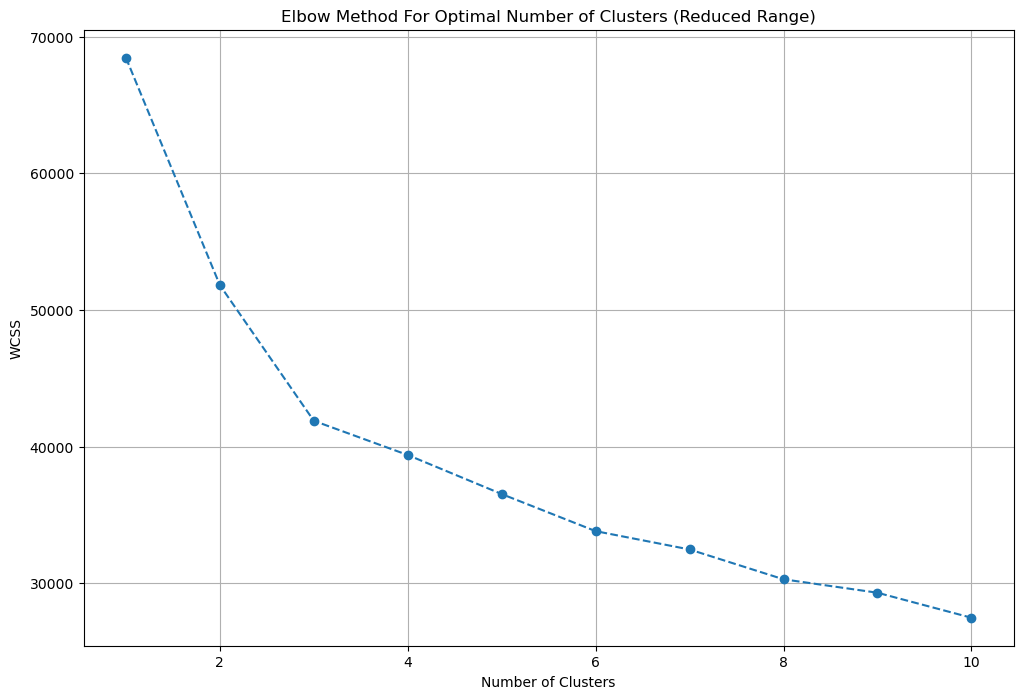

In [19]:
# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [20]:
n_clusters = 3

# Fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(scaled_data)

# Predict the cluster assignments for each row
cluster_assignments = kmeans.predict(scaled_data)

In [21]:
df = df.iloc[:,:-18]
df['furnishing_type'] = cluster_assignments
df.sample(5)[['furnishDetails','furnishing_type']]
# 0 -> unfurnished
# 1 -> semifurnished
# 2 -> furnished

,furnishDetails,furnishing_type
1085,"['5 Wardrobe', '1 Water Purifier', '5 Fan', '1...",0
1490,NaN,1
3455,"['1 Water Purifier', '6 Fan', '1 Exhaust Fan',...",0
2601,"['3 Wardrobe', '5 Fan', '2 Geyser', '5 Light',...",1
286,[],1


### 5. features

In [22]:
df['features'].sample(5)

1474    ['Feng Shui / Vaastu Compliant', 'Lift(s)', 'P...
2863    ['Security / Fire Alarm', 'Power Back-up', 'Fe...
490     ['Intercom Facility', 'Lift(s)', 'Maintenance ...
256     ['False Ceiling Lighting', 'Park', 'Low Densit...
2169             ['Intercom Facility', 'Lift(s)', 'Park']
Name: features, dtype: object

In [23]:
df['features'].isnull().sum()

635

In [24]:
apar_df = pd.read_csv('../Dataset/Raw/apartments.csv')
apar_df.sample(3)

,PropertyName,PropertySubName,NearbyLocations,LocationAdvantages,Link,PriceDetails,TopFacilities
152,Ashiana Amarah,"3, 4 BHK Apartment in Sector 93, Gurgaon","['Pranavananda International School', 'Kidzee ...","{'Pranavananda International School': '650 M',...",https://www.99acres.com/ashiana-amarah-sector-...,"{'3 BHK': {'building_type': 'Apartment', 'area...","['Swimming Pool', 'Flower Garden', 'Library', ..."
232,Emaar Mgf Palm Terraces Select,"3, 4, 5 BHK Apartment in Sector 66, Gurgaon","['Golf Course Ext Rd', 'DPS International Edge...","{'Golf Course Ext Rd': '900 Meter', 'DPS Inter...",https://www.99acres.com/emaar-mgf-palm-terrace...,"{'3 BHK': {'building_type': 'Apartment', 'area...","['Bowling Alley', 'Swimming Pool', 'Bar/Chill-..."
226,Antriksh Heights,"2, 3, 4 BHK Apartment in Sector 84, Gurgaon","['Society Park', 'MatriKiran High School', 'Ol...","{'Society Park': '2 mins', 'MatriKiran High Sc...",https://www.99acres.com/antriksh-heights-secto...,"{'2 BHK': {'building_type': 'Apartment', 'area...","['Food Court', 'Swimming Pool', 'School', 'Sau..."


In [25]:
apar_df['PropertyName'] = apar_df['PropertyName'].str.lower()
temp_df = df[df['features'].isnull()]
x = temp_df.merge(apar_df, left_on = 'society', right_on = 'PropertyName', how = 'left')['TopFacilities']

In [26]:
df.loc[temp_df.index, 'features'] = x.values
df['features'].isnull().sum()

481

In [27]:
# Convert the string representation of lists in the 'features' column to actual lists
df['features_list'] = df['features'].apply(lambda x: ast.literal_eval(x) if pd.notnull(x) and x.startswith('[') else [])

# Use MultiLabelBinarizer to convert the features list into a binary matrix
mlb = MultiLabelBinarizer()
features_binary_matrix = mlb.fit_transform(df['features_list'])

# Convert the binary matrix into a DataFrame
features_binary_df = pd.DataFrame(features_binary_matrix, columns=mlb.classes_)

In [28]:
features_binary_df.sample(5)

,24/7 Power Backup,24/7 Water Supply,24x7 Security,ATM,Aerobics Centre,Air Hockey,Airy Rooms,Amphitheatre,Automated Car Wash,Badminton Court,...,Visitors Parking,Volley Ball Court,Waiting Lounge,Waste Disposal,Water Softener Plant,Water Storage,Water purifier,Water softening plant,Wi-Fi Connectivity,Yoga/Meditation Area
3335,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,0,1,0,0
721,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,1,1,0,0
875,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
742,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,1,1,0,0,0
344,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


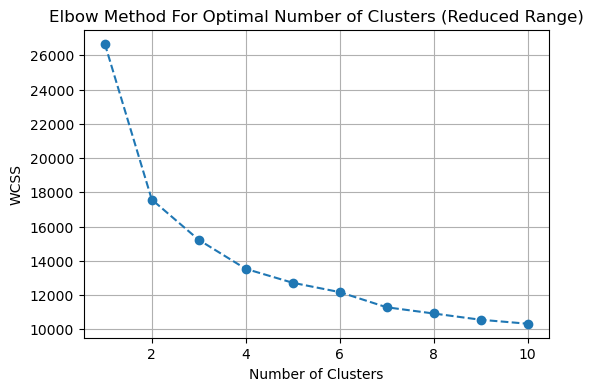

In [29]:
wcss_reduced = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(features_binary_df)
    wcss_reduced.append(kmeans.inertia_)

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(range(1,11), wcss_reduced, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters (Reduced Range)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [30]:
# Assigning weights based on perceived luxury contribution
weights = {
    '24/7 Power Backup': 8, '24/7 Water Supply': 4, '24x7 Security': 7, 'ATM': 4, 'Aerobics Centre': 6,
    'Airy Rooms': 8, 'Amphitheatre': 7, 'Badminton Court': 7, 'Banquet Hall': 8, 'Bar/Chill-Out Lounge': 9,
    'Barbecue': 7, 'Basketball Court': 7, 'Billiards': 7, 'Bowling Alley': 8, 'Business Lounge': 9,
    'CCTV Camera Security': 8, 'Cafeteria': 6, 'Car Parking': 6, 'Card Room': 6,
    'Centrally Air Conditioned': 9, 'Changing Area': 6, "Children's Play Area": 7, 'Cigar Lounge': 9,
    'Clinic': 5, 'Club House': 9, 'Concierge Service': 9, 'Conference room': 8, 'Creche/Day care': 7,
    'Cricket Pitch': 7, 'Doctor on Call': 6, 'Earthquake Resistant': 5, 'Entrance Lobby': 7,
    'False Ceiling Lighting': 6, 'Feng Shui / Vaastu Compliant': 5, 'Fire Fighting Systems': 8,
    'Fitness Centre / GYM': 8,
    'Flower Garden': 7,
    'Food Court': 6,
    'Foosball': 5,
    'Football': 7,
    'Fountain': 7,
    'Gated Community': 7,
    'Golf Course': 10,
    'Grocery Shop': 6,
    'Gymnasium': 8,
    'High Ceiling Height': 8,
    'High Speed Elevators': 8,
    'Infinity Pool': 9,
    'Intercom Facility': 7,
    'Internal Street Lights': 6,
    'Internet/wi-fi connectivity': 7,
    'Jacuzzi': 9,
    'Jogging Track': 7,
    'Landscape Garden': 8,
    'Laundry': 6,
    'Lawn Tennis Court': 8,
    'Library': 8,
    'Lounge': 8,
    'Low Density Society': 7,
    'Maintenance Staff': 6,
    'Manicured Garden': 7,
    'Medical Centre': 5,
    'Milk Booth': 4,
    'Mini Theatre': 9,
    'Multipurpose Court': 7,
    'Multipurpose Hall': 7,
    'Natural Light': 8,
    'Natural Pond': 7,
    'Park': 8,
    'Party Lawn': 8,
    'Piped Gas': 7,
    'Pool Table': 7,
    'Power Back up Lift': 8,
    'Private Garden / Terrace': 9,
    'Property Staff': 7,
    'RO System': 7,
    'Rain Water Harvesting': 7,
    'Reading Lounge': 8,
    'Restaurant': 8,
    'Salon': 8,
    'Sauna': 9,
    'Security / Fire Alarm': 9,
    'Security Personnel': 9,
    'Separate entry for servant room': 8,
    'Sewage Treatment Plant': 6,
    'Shopping Centre': 7,
    'Skating Rink': 7,
    'Solar Lighting': 6,
    'Solar Water Heating': 7,
    'Spa': 9,
    'Spacious Interiors': 9,
    'Squash Court': 8,
    'Steam Room': 9,
    'Sun Deck': 8,
    'Swimming Pool': 8,
    'Temple': 5,
    'Theatre': 9,
    'Toddler Pool': 7,
    'Valet Parking': 9,
    'Video Door Security': 9,
    'Visitor Parking': 7,
    'Water Softener Plant': 7,
    'Water Storage': 7,
    'Water purifier': 7,
    'Yoga/Meditation Area': 7
}
# Calculate luxury score for each row
luxury_score = features_binary_df[list(weights.keys())].multiply(list(weights.values())).sum(axis=1)

In [31]:
df['luxury_score'] = luxury_score

### Export

In [32]:
pd.set_option('display.max_columns', None)
df.sample(3)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,additionalRoom,floorNum,facing,agePossession,nearbyLocations,furnishDetails,features,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,features_list,luxury_score
2870,flat,hcbs sports ville,sohna road,0.32,5517.0,580.0,Carpet area: 580 (53.88 sq.m.),2.0,2.0,1,not available,7.0,NaN,New Property,"['The roadside cafe', 'GD Goenka Mess', 'ROyal...",NaN,"['Intercom Facility', 'Lift(s)', 'Swimming Poo...",NaN,NaN,580.0,0,0,0,0,0,1,"[Intercom Facility, Lift(s), Swimming Pool, Pa...",37
2997,flat,ss the leaf,sector 85,1.77,7350.0,2408.0,Super Built up area 2408(223.71 sq.m.),3.0,4.0,3+,store room,7.0,South-West,New Property,"['Sapphire 83 Mall', 'Dwarka Expressway', 'Cen...","['5 AC', 'No Bed', 'No Chimney', 'No Curtains'...","['Security / Fire Alarm', 'Power Back-up', 'In...",2408.0,NaN,NaN,0,0,1,0,0,1,"[Security / Fire Alarm, Power Back-up, Interco...",107
2706,flat,eldeco accolade,sohna road,0.95,6554.0,1449.0,Super Built up area 1457(135.36 sq.m.)Carpet a...,2.0,2.0,3,study room,8.0,North-East,Under Construction,"['Global City Centre', 'Sohna Road', 'Damdama ...",[],"['Feng Shui / Vaastu Compliant', 'Security / F...",1457.0,NaN,849.0,1,0,0,0,0,1,"[Feng Shui / Vaastu Compliant, Security / Fire...",42


In [33]:
# cols to drop -> nearbyLocations,furnishDetails, features,features_list, additionalRoom
df.drop(columns=['nearbyLocations','furnishDetails','features','features_list','additionalRoom'],inplace=True)

In [34]:
df.sample(3)

,property_type,society,sector,price,price_per_sqft,area,areaWithType,bedRoom,bathroom,balcony,floorNum,facing,agePossession,super_built_up_area,built_up_area,carpet_area,study room,servant room,store room,pooja room,others,furnishing_type,luxury_score
1859,flat,raheja atlantis,sector 31,5.50,18688.0,2943.0,Super Built up area 2943(273.41 sq.m.),4.0,5.0,3+,1.0,North,Relatively New,2943.0,NaN,NaN,1,1,0,1,0,1,81
400,house,international city by sobha phase 1,sector 109,6.15,27333.0,2250.0,Plot area 270(225.75 sq.m.)Built Up area: 270 ...,5.0,5.0,3+,3.0,West,Relatively New,NaN,270.0,250.0,0,1,1,1,0,0,130
3440,flat,indiabulls enigma,sector 110,3.79,9895.0,3830.0,Super Built up area 3830(355.82 sq.m.),5.0,5.0,3,4.0,South-West,Relatively New,3830.0,NaN,NaN,0,1,0,0,1,1,125


In [35]:
df.shape

(3803, 23)

In [36]:
df.to_csv('../Dataset/Processed/gurgaon_properties_cleaned_v2.csv',index=False)